In [10]:
import numpy as np
import numba
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys
import os

from eigenwell.src import grid, grid_preconditioner
from eigenwell.src.constants import *

#import eigenwell.boundary
print(os.listdir())


['2d photonic crystal.ipynb', 'check_pml.ipynb', '3D waveguide solve.ipynb', '__init__.py', 'modes of a waveguide.ipynb', 'IMI-MIM.ipynb', 'test_pml_grid_preconditioners.ipynb', '.ipynb_checkpoints', '1D Bragg Mirror.ipynb']


## Equations for a general waveguide with propagation constant $\beta$ in z
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}
\begin{equation}
    \omega^2 \mu_0 T_{\epsilon_y}h_x - T_{\epsilon_y} D_y^{f}T_{\epsilon_z}^{-1}\bigg(D_x^{b}h_y - D_y^{b}h_x\bigg) + D_x^{b}\bigg(D_x^{f}h_x - D_y^{f}h_y \bigg) = \beta^2 h_x
\end{equation}

In full operator notation
\begin{equation}
    \omega^2 \mu_0 \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}
    +
    \begin{bmatrix}
        T_{\epsilon_y} & \\
        & T_{\epsilon_x} 
    \end{bmatrix}     \begin{bmatrix}
        -D_y^{f} \\
        D_x^{f}
    \end{bmatrix} T_{\epsilon_z}^{-1} \begin{bmatrix}
        -D_y^{b} &
        D_x^{b}
    \end{bmatrix} +\begin{bmatrix}
        D_x^{b} \\
        D_y^{b}
    \end{bmatrix} \begin{bmatrix}
        D_x^{f} &
        D_y^{f}
    \end{bmatrix}
\end{equation}



[-2.5e-07, 2.5e-07]


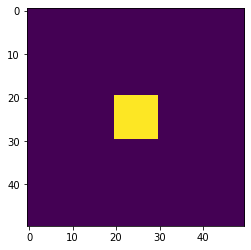

(5000, 2500)
(5000, 5000)
1.8836715459105513 1.2566370614359173e-06 25640


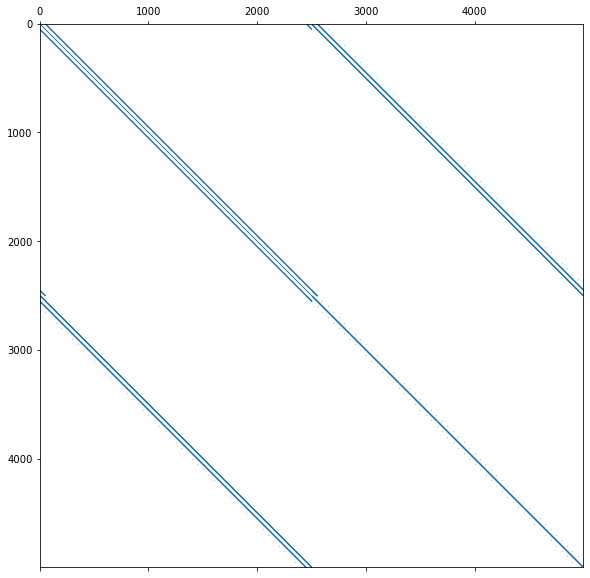

In [16]:
L0 = 1e-6

N = [50,50]
Npml = [10,10]
dL = [0.01*L0, 0.01*L0]
Lx, Ly = [N[0]*dL[0], N[1]*dL[1]]
xrange = [-Lx/2, Lx/2]
yrange = [-Ly/2, Ly/2]
print(xrange)

wvlen = 1e-6;

omega = 2*np.pi*C0/wvlen;

pml = grid_preconditioner.PML(N,Npml, omega);
pml.Soperators(xrange, yrange);

epsilon = np.ones(N)
epsilon[20:30, 20:30] = 6.25
plt.figure();
plt.imshow(epsilon);
plt.show();


Tez = sp.diags(EPSILON0*epsilon.flatten())
Tey = sp.diags(EPSILON0*epsilon.flatten())
Tex = sp.diags(EPSILON0*epsilon.flatten())
invTez = sp.diags(1/(EPSILON0*epsilon.flatten()))

fd = grid.FiniteDifference(dL,N)

fd.make_derivatives(PML = pml)
Dxf = fd.Dxf;
Dxb = fd.Dxb;
Dyf = fd.Dyf;
Dyb = fd.Dyb;

## generate operator
Dop1 = sp.bmat([[-Dyf], [Dxf]])
print(Dop1.shape)

Dop2 = sp.bmat([[-Dyb,Dxb]])

Dop3 = sp.bmat([[Dxb], [Dyb]])

Dop4 = sp.bmat([[Dxf,Dyf]])

Tep = sp.block_diag((Tey, Tex))


A = omega**2*MU0*Tep + Tep@(Dop1)@invTez@(Dop2) + Dop3@Dop4
print(A.shape)
plt.figure(figsize = (10,10))
plt.spy(Tep@(Dop1)@invTez@(Dop2), markersize = 0.1)

print(omega*1e-15, MU0, A.count_nonzero())

In [14]:
## use eigs
from scipy.sparse.linalg import eigs
K = 2
vals, vecs = eigs(A, k = K, which = 'SM')

KeyboardInterrupt: 

In [ ]:
for i in range(K):
    v = vecs[:,i]
    hx = v[0:np.prod(N)].reshape(N)
    hy = v[np.prod(N):].reshape(N)
    plt.figure();
    plt.imshow(np.abs(hy), cmap = 'hot')
    plt.colorbar();